In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
def get_grnas_id_co_files_to_use():
    co_sgrnas_ids = set()
    co_df = pd.read_csv('Original Files/co2.csv')
    # remove all rows where CleanReadsNumber < 200
    co_df = co_df[co_df['CleanReadsNumber'] >= 200]
    co_sgrnas_ids.update(co_df['Surrogate ID'].values)

    co_df = pd.read_csv('Original Files/co4.csv')
    # remove all rows where CleanReadsNumber < 200
    co_df = co_df[co_df['CleanReadsNumber'] >= 200]
    co_sgrnas_ids.intersection_update(co_df['Surrogate ID'].values)

    

    return co_sgrnas_ids

In [3]:
def calculate_spearman_crispron():
    co_grnas_ids = get_grnas_id_co_files_to_use()
    
    # Load the original data files
    first_co_df = pd.read_csv('Original Files/co2.csv')
    second_co_df = pd.read_csv('Original Files/co4.csv')
    
    # Filter the dataframes to include only the rows with 'Surrogate ID' present in 'co_grnas_ids'
    first_co_df = first_co_df[first_co_df['Surrogate ID'].isin(co_grnas_ids)]
    second_co_df = second_co_df[second_co_df['Surrogate ID'].isin(co_grnas_ids)]
    
    # Merge the dataframes on 'Surrogate ID' to align the data
    merged_df = pd.merge(first_co_df[['Surrogate ID', 'total_indel_eff']], 
                         second_co_df[['Surrogate ID', 'total_indel_eff']], 
                         on='Surrogate ID', 
                         suffixes=('_co2', '_co4'))
    
    # Calculate the spearman correlation between the two aligned columns
    spearman_corr = merged_df['total_indel_eff_co2'].corr(merged_df['total_indel_eff_co4'], method='spearman')
    print('Spearman correlation between co2 and co4 dataframes: ', spearman_corr)


In [4]:
print(len(get_grnas_id_co_files_to_use()))

calculate_spearman_crispron()

10592
Spearman correlation between co2 and co4 dataframes:  0.9136957581571094


In [5]:
def create_crispron_csv(length =23):
    sequences_df = pd.read_csv('Original Files/co_sequences.csv')
    original_df_1 = pd.read_csv('Original Files/co2.csv')
    original_df_2 = pd.read_csv('Original Files/co4.csv') 
    LABEL_COLUMN = 'total_indel_eff'


    rows = []
    if length== 23:
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[128:]
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[:-19]
    elif length == 21:
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[128:]
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[:-21]
    elif length == 30:
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[124:]
        sequences_df['sequences (5\'to3\')'] = sequences_df['sequences (5\'to3\')'].str[:-16]

    #print(sequences_df.head())
    grnas_ids = get_grnas_id_co_files_to_use()

    for grna_id in grnas_ids:
        full_sequence = sequences_df[sequences_df['Surrogate ID'] == grna_id]['sequences (5\'to3\')'].values[0]
        original_df_1_row = original_df_1[original_df_1['Surrogate ID'] == grna_id]
        original_df_2_row = original_df_2[original_df_2['Surrogate ID'] == grna_id]

        # get total_indel_eff columm for each
        total_indel_eff_1 = original_df_1_row[LABEL_COLUMN].values[0]
        total_indel_eff_2 = original_df_2_row[LABEL_COLUMN].values[0]

        # get mean
        mean_total_indel_eff = np.mean([total_indel_eff_1, total_indel_eff_2])

        rows.append([full_sequence, mean_total_indel_eff])
    
    new_co_dataframe = pd.DataFrame(rows, columns=['Sequence', LABEL_COLUMN])
    new_co_dataframe.to_csv('Combined Files/co_no_kim{}.csv'.format(length), index=False)


In [6]:
create_crispron_csv(length=23)
create_crispron_csv(length=21)
create_crispron_csv(length=30)

In [7]:
def get_kim_grnas():
    kim_file_paths = ['Original Files/kim1.csv', 'Original Files/kim2.csv']
    kim_sgrnas = set()
    for kim_file_path in kim_file_paths:
        kim_df = pd.read_csv(kim_file_path)
        #print(kim_df.columns)
        kim_sgrnas.update(kim_df['Target context sequence (4+20+3+3)'].values)
    return kim_sgrnas

In [8]:
def get_kim_csv():
    #LABEL_COLUMN = 'Indel frequencies (%)'
    LABEL_COLUMN = 'Background subtracted indel frequencies\n(average, %)'
    original_df_1 = pd.read_csv('Original Files/kim1.csv')
    original_df_2 = pd.read_csv('Original Files/kim2.csv')
    rows = []
    grnas_kim = get_kim_grnas()

    for grna_kim in grnas_kim:
        original_df_1_row = original_df_1[original_df_1['Target context sequence (4+20+3+3)'] == grna_kim]
        original_df_2_row = original_df_2[original_df_2['Target context sequence (4+20+3+3)'] == grna_kim]

        if original_df_1_row.empty:
            #print(original_df_2_row)
            total_indel_eff_2 = original_df_2_row[LABEL_COLUMN].values[0]
            rows.append([grna_kim, total_indel_eff_2])

        elif original_df_2_row.empty:
            total_indel_eff_1 = original_df_1_row['Background subtracted indel (%)'].values[0]
            rows.append([grna_kim, total_indel_eff_1])
        else:
            total_indel_eff_1 = original_df_1_row['Background subtracted indel (%)'].values[0]
            total_indel_eff_2 = original_df_2_row[LABEL_COLUMN].values[0]
            mean_total_indel_eff = np.mean([total_indel_eff_1, total_indel_eff_2])
            rows.append([grna_kim, mean_total_indel_eff])

    new_kim_dataframe = pd.DataFrame(rows, columns=['Sequence', LABEL_COLUMN])
    new_kim_dataframe.to_csv('Combined Files/kim_combined.csv', index=False)


    



In [9]:
get_kim_csv()

### Linear Rescaling

Number of intersecting sequences: 49


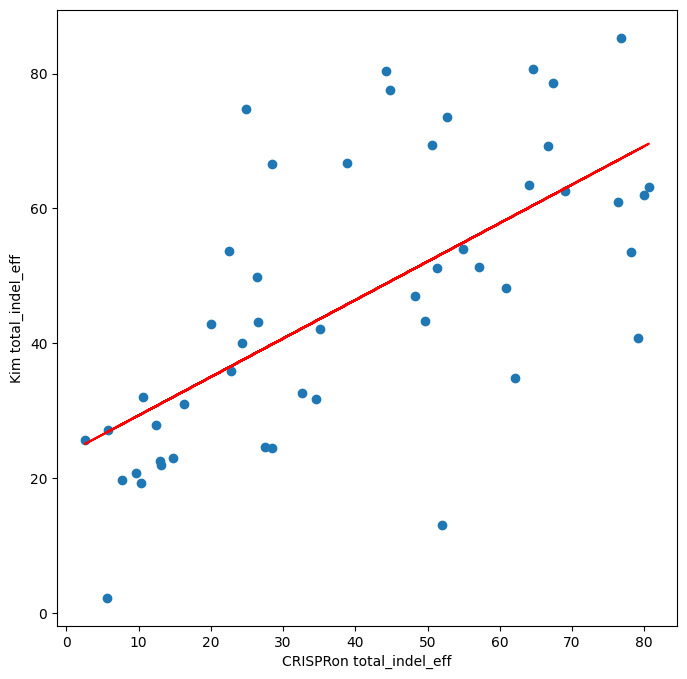

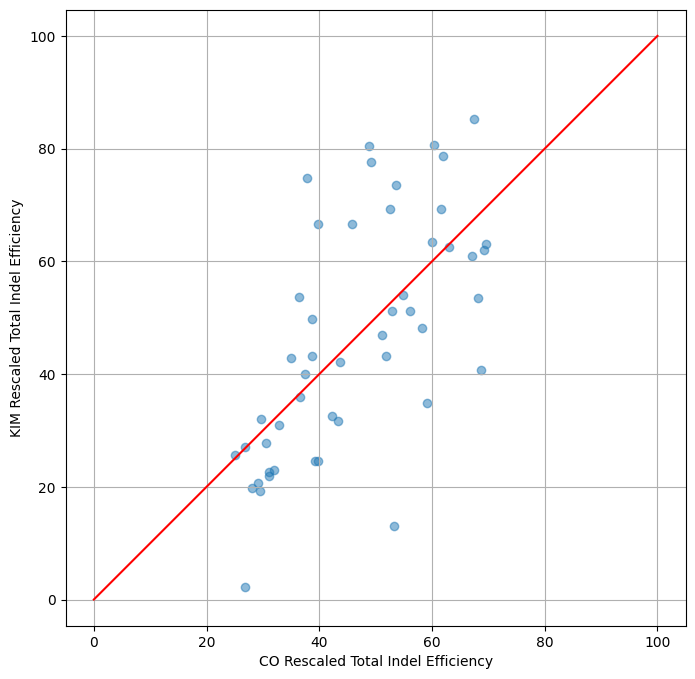

Slope (scale factor): 0.5706007711940538
Intercept (offset): 23.575098863490133


In [16]:
# Load the datasets
co_no_kim_df_30 = pd.read_csv('Combined Files/co_no_kim30.csv')
kim_combined_df = pd.read_csv('Combined Files/kim_combined.csv')

kim_combined_df.rename(columns={'Background subtracted indel frequencies\n(average, %)': 'total_indel_eff'}, inplace=True)

# Assuming both DataFrames have a 'Sequence' column and a 'total_indel_eff' metric you want to compare,

# Merge the dataframes on 'Sequence' to ensure proper alignment
merged_df = pd.merge(co_no_kim_df_30[['Sequence', 'total_indel_eff']],
                      kim_combined_df[['Sequence', 'total_indel_eff']],
                        on='Sequence',
                        suffixes=('_co', '_kim'))

print(f"Number of intersecting sequences: {len(merged_df)}")

# Calculate the linear regression between the aligned 'total_indel_eff' data
slope, intercept, r_value, p_value, std_err = linregress(merged_df['total_indel_eff_co'], merged_df['total_indel_eff_kim'])




# Plotting
plt.figure(figsize=(8, 8)) # Ensuring the plot is square

plt.scatter(merged_df['total_indel_eff_co'], merged_df['total_indel_eff_kim'])
plt.xlabel('CRISPRon total_indel_eff')
plt.ylabel('Kim total_indel_eff')
plt.plot(merged_df['total_indel_eff_co'], slope * merged_df['total_indel_eff_co'] + intercept, color='red')

plt.show()


#kim_combined_df['total_indel_eff_rescaled'] = kim_combined_df['total_indel_eff'] * slope + intercept 
#co_no_kim_df_30 = co_no_kim_df_30.rename(columns={'total_indel_eff': 'total_indel_eff_rescaled'})

co_no_kim_df_30 ['total_indel_eff_rescaled'] = co_no_kim_df_30['total_indel_eff'] * slope + intercept
kim_combined_df.rename(columns={'total_indel_eff': 'total_indel_eff_rescaled'}, inplace=True)

# Concatenate both datasets
all_sequences = pd.concat([co_no_kim_df_30[['Sequence', 'total_indel_eff_rescaled']], 
                           kim_combined_df[['Sequence', 'total_indel_eff_rescaled']]])

# show example of resacled sequences in both dataframes
merged_sequences = merged_df['Sequence'].values
# Lists to store the data for plotting
# Lists for the plot
sequences = []
co_rescaled_values = []
kim_rescaled_values = []

for sequence in merged_sequences:
    co_value = co_no_kim_df_30[co_no_kim_df_30['Sequence'] == sequence]['total_indel_eff_rescaled'].values[0]
    kim_value = kim_combined_df[kim_combined_df['Sequence'] == sequence]['total_indel_eff_rescaled'].values[0]
    
    sequences.append(sequence)
    co_rescaled_values.append(co_value)
    kim_rescaled_values.append(kim_value)

# Plotting
plt.figure(figsize=(8, 8)) # Ensuring the plot is square
# range is 0 to 100
plt.xlim(0, 90)
plt.ylim(0, 90)
# show y=x line
plt.plot([0, 100], [0, 100], color='red')
plt.scatter(co_rescaled_values, kim_rescaled_values, alpha=0.5)
plt.xlabel('CO Rescaled Total Indel Efficiency')
plt.ylabel('KIM Rescaled Total Indel Efficiency')

# Setting the same limits for both axes based on the min and max of all values
all_values = co_rescaled_values + kim_rescaled_values
min_val, max_val = min(all_values), max(all_values)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Ensuring that one unit on the x-axis is the same as one unit on the y-axis
plt.axis('equal')


plt.show()


# Group by sequence and calculate average for common sequences
# This will automatically handle unique sequences by just passing their original values
final_df = all_sequences.groupby('Sequence', as_index=False).mean()

# save the final dataframe
final_df.to_csv('Combined Files/co_and_kim_30.csv', index=False)

# remove 3 from the end
final_df['Sequence'] = final_df['Sequence'].str[:-3]
# remove 4 from the start
final_df['Sequence'] = final_df['Sequence'].str[4:]

# save the final dataframe
final_df.to_csv('Combined Files/co_and_kim_23.csv', index=False)

# remove 2 from the start
final_df['Sequence'] = final_df['Sequence'].str[2:]

# save the final dataframe
final_df.to_csv('Combined Files/co_and_kim_21.csv', index=False)


print(f"Slope (scale factor): {slope}")
print(f"Intercept (offset): {intercept}")


In [11]:
# Get size of sequences in either one'
co_no_kim_df_30 = pd.read_csv('Combined Files/co_no_kim30.csv')
kim_combined_df = pd.read_csv('Combined Files/kim_combined.csv')
sequences = set(co_no_kim_df_30['Sequence'].values).union(set(kim_combined_df['Sequence'].values))
print(len(sequences))

23902
